# Ensemble Methods: Bagging, Random Forests, and Boosting

This notebook provides a comprehensive overview of three major ensemble methods in machine learning: **Bagging**, **Random Forests**, and **Boosting**. We will cover the theory, equations, practical examples using real datasets, and discuss best practices, pitfalls, and interpretation. Visualizations and review questions are included to reinforce learning.

---

## Table of Contents
1. Introduction to Ensemble Methods
2. Bias-Variance Tradeoff
3. Bagging (Bootstrap Aggregation)
    - Intuition & Theory
    - Mathematical Formulation
    - Algorithm Steps
    - Example: Soil pH Regression
    - Visualizing Bagging
4. Random Forests
    - Intuition & Theory
    - Mathematical Formulation
    - Algorithm Steps
    - Example: Soil pH Regression
    - Feature Importance & Visualization
    - Practical Tips & Pitfalls
5. Boosting
    - AdaBoost: Intuition, Theory, and Example
    - Gradient Boosting: Intuition, Theory, and Example
    - Histogram-based Boosting
    - Visualizing Boosting
    - Practical Tips & Pitfalls
6. Hyperparameter Tuning & Parallelization
7. Summary & Review Questions

---

## 1. Introduction to Ensemble Methods

Ensemble methods combine predictions from multiple base estimators to improve generalization and robustness. The main types are:
- **Bagging**: Reduces variance by averaging predictions from models trained on different random samples.
- **Random Forests**: Adds feature randomness to bagging, further reducing correlation between trees.
- **Boosting**: Sequentially builds models that focus on correcting errors of previous models, reducing bias.

**Why use ensembles?**
- Single models (e.g., a single decision tree) can be unstable and sensitive to data noise.
- Ensembles aggregate multiple models to reduce overfitting and improve predictive accuracy.
- Widely used in competitions (e.g., Kaggle) and real-world applications.

---

## 2. Bias-Variance Tradeoff

The **bias-variance tradeoff** is central to understanding ensemble methods:
- **Bias**: Error from erroneous assumptions (underfitting). High bias can cause a model to miss relevant relations (underfit).
- **Variance**: Error from sensitivity to small fluctuations in the training set (overfitting). High variance can cause a model to model the random noise in the training data.

**Bagging and Random Forests** mainly reduce variance, while **boosting** aims to reduce bias.

**Expected Error Decomposition:**
$$
\text{Expected Error} = \text{Bias}^2 + \text{Variance} + \text{Irreducible Error}
$$

**Visualization:**
- High bias: Model is too simple (e.g., straight line for nonlinear data).
- High variance: Model is too complex (e.g., fits every data point).
- Ensembles help find a balance.

---

## 3. Bagging (Bootstrap Aggregation)

### Intuition & Theory
Bagging (Bootstrap Aggregation) is an ensemble method that trains multiple models (usually decision trees) on different bootstrap samples (random samples with replacement) and averages their predictions. This reduces variance and helps prevent overfitting.

**When to use bagging?**
- When your base model is high-variance (e.g., decision trees).
- When you want to stabilize predictions and reduce overfitting.

### Mathematical Formulation
**Bagging Prediction (Regression):**
$$
\hat{f}_{\text{bag}}(x) = \frac{1}{B} \sum_{b=1}^B \hat{f}^{(b)}(x)
$$
where $\hat{f}^{(b)}(x)$ is the prediction from the $b$-th model.

### Algorithm Steps
1. Draw $B$ bootstrap samples from the dataset (sample with replacement).
2. Train a base estimator (e.g., decision tree) on each sample.
3. For regression, average the predictions; for classification, use majority vote.

### Practical Tips
- Bagging works best with unstable models (e.g., deep trees, not linear regression).
- Increasing the number of estimators ($B$) generally improves performance but increases computation.

### Visualizing Bagging
- Each model sees a slightly different dataset, so their errors are less correlated.
- Averaging predictions smooths out noise.

Bagging RMSE: 0.952
Bagging R^2 Score: 0.018


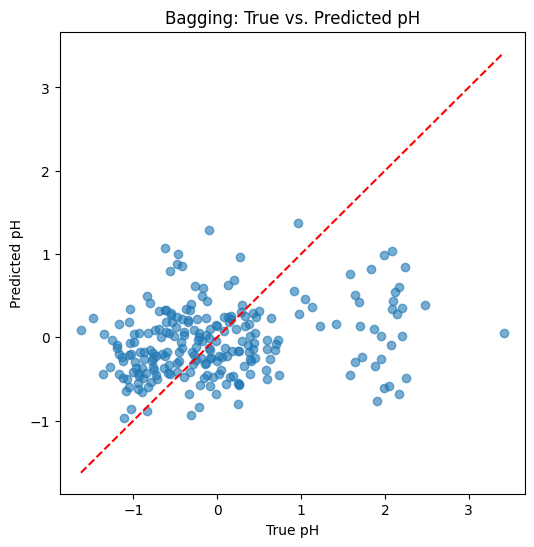

Bagging RMSE: 0.952
Bagging R^2 Score: 0.018


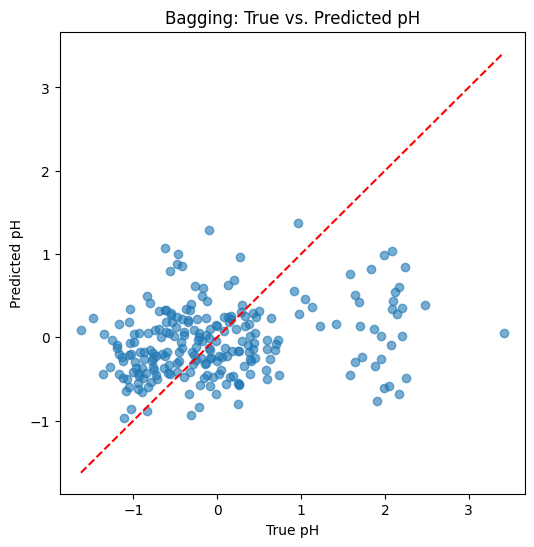

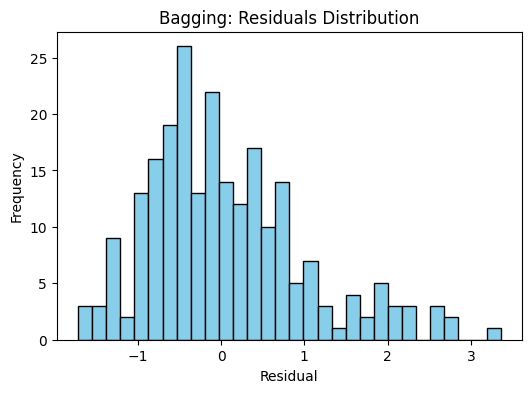

Bagging RMSE: 0.952
Bagging R^2 Score: 0.018


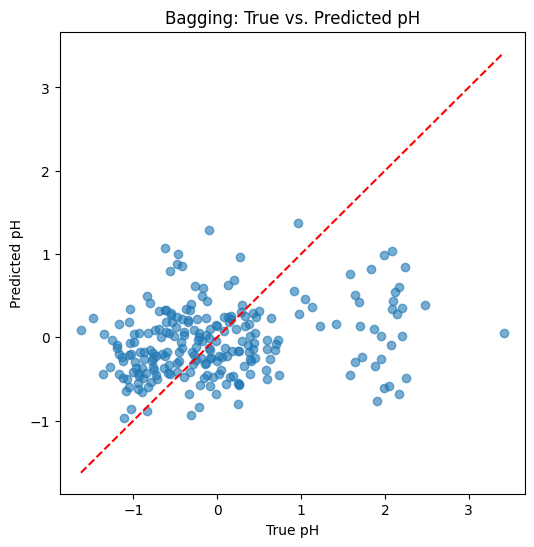

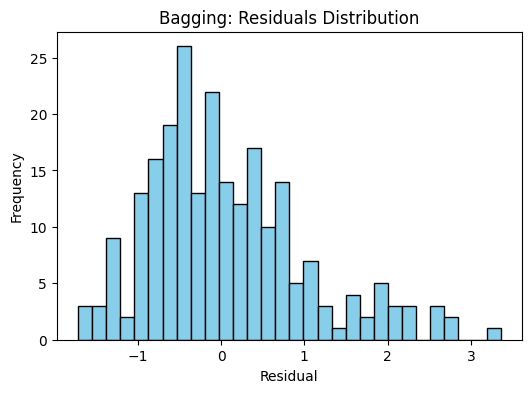

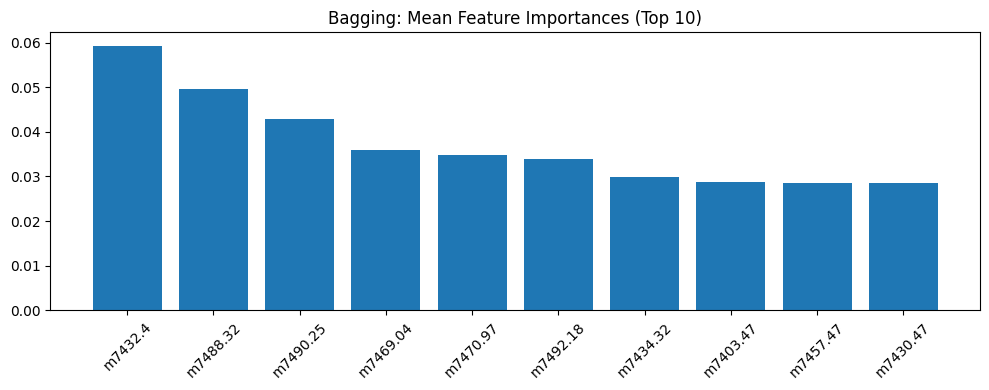

In [ ]:
# Example: Bagging for Soil pH Regression (data/training.csv)
# This example demonstrates how bagging reduces variance in regression tasks.
import pandas as pd
import numpy as np
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load data
soil = pd.read_csv('data/training.csv')
features = [col for col in soil.columns if col.startswith('m')]
X = soil[features[:50]].dropna()
y = soil.loc[X.index, 'pH']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# For scikit-learn >= 1.2, use 'estimator' instead of 'base_estimator'
import sklearn
bag_kwargs = {
    'n_estimators': 50,
    'random_state': 42
}
if int(sklearn.__version__.split('.')[1]) >= 2:
    bag_kwargs['estimator'] = DecisionTreeRegressor()
else:
    bag_kwargs['base_estimator'] = DecisionTreeRegressor()

bagging = BaggingRegressor(**bag_kwargs)
bagging.fit(X_train, y_train)
y_pred = bagging.predict(X_test)

print(f"Bagging RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}")
print(f"Bagging R^2 Score: {r2_score(y_test, y_pred):.3f}")

# Visualize predictions vs. true values
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel('True pH')
plt.ylabel('Predicted pH')
plt.title('Bagging: True vs. Predicted pH')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

# Visualize residuals
residuals = y_test - y_pred
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=30, color='skyblue', edgecolor='k')
plt.title('Bagging: Residuals Distribution')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

# Feature importance (mean over all trees)
if hasattr(bagging, 'estimators_'):
    importances = np.mean([
        est.feature_importances_ for est in bagging.estimators_
    ], axis=0)
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(10,4))
    plt.title("Bagging: Mean Feature Importances (Top 10)")
    plt.bar(range(10), importances[indices[:10]], align="center")
    plt.xticks(range(10), [features[i] for i in indices[:10]], rotation=45)
    plt.tight_layout()
    plt.show()

---

## 4. Random Forests

### Intuition & Theory
A **Random Forest** is an ensemble of decision trees, each trained on a bootstrap sample and, at each split, considers only a random subset of features. This reduces correlation between trees and further reduces variance.

**Why randomize features?**
- If some features are very strong predictors, all trees in bagging may look similar.
- Randomly selecting features at each split increases diversity among trees, improving generalization.

### Mathematical Formulation
**Random Forest Prediction (Regression):**
$$
\hat{f}_{\text{RF}}(x) = \frac{1}{B} \sum_{b=1}^B \hat{f}^{(b)}(x)
$$

### Algorithm Steps
1. For each tree, draw a bootstrap sample from the data.
2. At each split, select a random subset of features and find the best split among them.
3. Aggregate predictions (average for regression, majority vote for classification).

### Practical Tips & Pitfalls
- Use `n_jobs=-1` to parallelize tree building.
- Tune `max_features` to control tree diversity.
- Too many trees can slow down prediction, but rarely hurt accuracy.
- Random Forests are robust to overfitting, but can still overfit on noisy data.

Random Forest RMSE: 0.945
Random Forest R^2 Score: 0.031


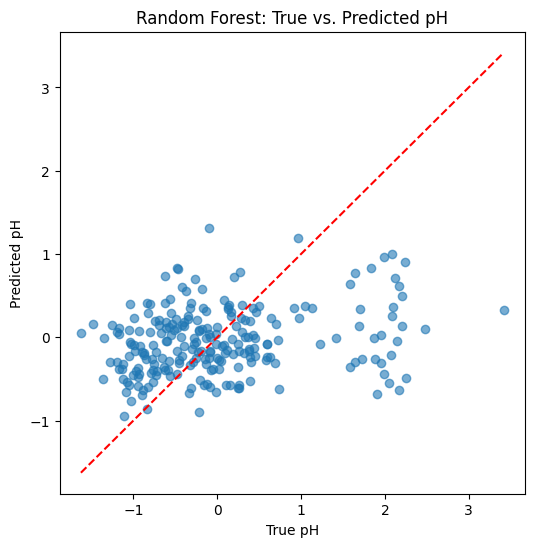

Random Forest RMSE: 0.945
Random Forest R^2 Score: 0.031


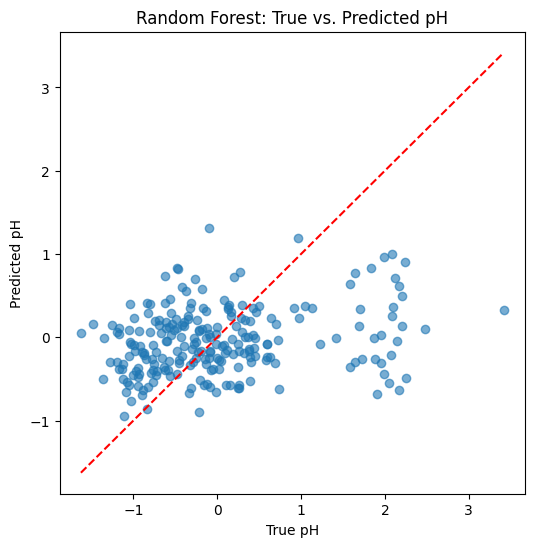

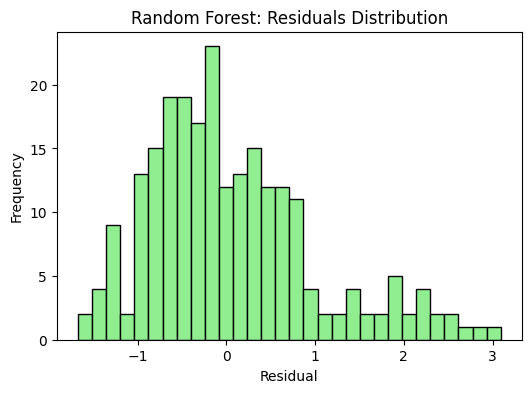

In [ ]:
# Example: Random Forest for Soil pH Regression
# Random Forests further reduce variance by decorrelating trees.
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

rf = RandomForestRegressor(n_estimators=100, max_features=20, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print(f"Random Forest RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_rf)):.3f}")
print(f"Random Forest R^2 Score: {r2_score(y_test, y_pred_rf):.3f}")

# Visualize predictions vs. true values
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_rf, alpha=0.6)
plt.xlabel('True pH')
plt.ylabel('Predicted pH')
plt.title('Random Forest: True vs. Predicted pH')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

# Visualize residuals
residuals_rf = y_test - y_pred_rf
plt.figure(figsize=(6,4))
plt.hist(residuals_rf, bins=30, color='lightgreen', edgecolor='k')
plt.title('Random Forest: Residuals Distribution')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

### Feature Importance in Random Forests
Random Forests provide feature importances based on how much each feature decreases impurity across all trees. This helps interpret which features are most influential in predictions.

**Visualization:**
- Plot the top features to see which variables matter most.
- Useful for feature selection and understanding the model.

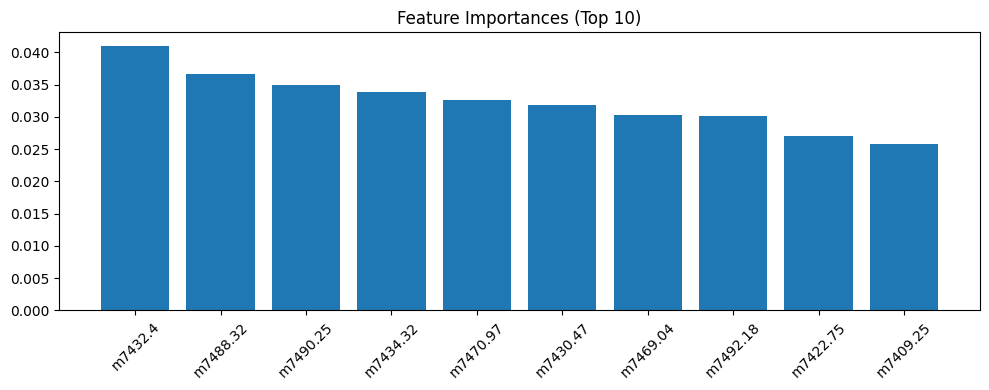

In [ ]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10,4))
plt.title("Feature Importances (Top 10)")
plt.bar(range(10), importances[indices[:10]], align="center")
plt.xticks(range(10), [features[i] for i in indices[:10]], rotation=45)
plt.tight_layout()
plt.show()

---

## 5. Boosting

### AdaBoost: Intuition & Theory
Boosting builds models sequentially, each focusing on correcting the errors of the previous ones. **AdaBoost** assigns higher weights to misclassified samples, so subsequent models focus on the "hard" cases.

**When to use boosting?**
- When you want to reduce bias and improve accuracy on complex patterns.
- When your base model is weak (e.g., shallow trees or "stumps").

**AdaBoost Classifier Equation:**
$$
F(x) = \text{sign}\left(\sum_{m=1}^M \alpha_m h_m(x)\right)
$$
where $h_m(x)$ is the $m$-th weak learner and $\alpha_m$ is its weight.

### Algorithm Steps
1. Initialize weights equally for all samples.
2. For each iteration, fit a weak learner and compute its error.
3. Increase weights for misclassified samples.
4. Combine weak learners using weighted majority vote.

### Practical Tips
- AdaBoost is sensitive to noisy data and outliers.
- Works best with weak, high-bias models (e.g., stumps).

AdaBoost Accuracy: 0.584


C:\Users\DELL\AppData\Local\Temp\ipykernel_13800\4219097930.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  mlb = pd.read_csv('data/mlb.txt', delim_whitespace=True, quotechar='"')


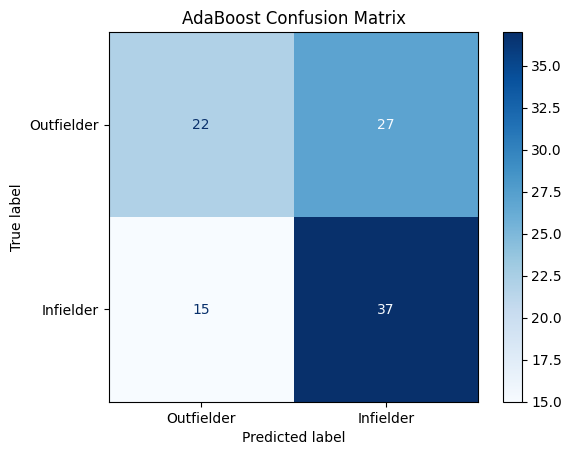

In [ ]:
# Example: AdaBoost for MLB Position Classification (data/mlb.txt)
# This example demonstrates boosting for binary classification.
import pandas as pd
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

mlb = pd.read_csv('data/mlb.txt', delim_whitespace=True, quotechar='"')
mlb = mlb[mlb['PosCategory'].isin(['Infielder', 'Outfielder'])].dropna(subset=['Height', 'Weight', 'Age', 'PosCategory'])
X = mlb[['Height', 'Weight', 'Age']]
y = (mlb['PosCategory'] == 'Infielder').astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# For scikit-learn >= 1.2, use 'estimator' instead of 'base_estimator'
import sklearn
ada_kwargs = {
    'n_estimators': 100,
    'random_state': 42
}
if int(sklearn.__version__.split('.')[1]) >= 2:
    ada_kwargs['estimator'] = DecisionTreeClassifier(max_depth=1)
else:
    ada_kwargs['base_estimator'] = DecisionTreeClassifier(max_depth=1)

ada = AdaBoostClassifier(**ada_kwargs)
ada.fit(X_train, y_train)
y_pred = ada.predict(X_test)
print(f"AdaBoost Accuracy: {accuracy_score(y_test, y_pred):.3f}")

# Visualization: Confusion Matrix
ConfusionMatrixDisplay.from_estimator(ada, X_test, y_test, display_labels=['Outfielder', 'Infielder'], cmap='Blues')
plt.title('AdaBoost Confusion Matrix')
plt.show()

### Gradient Boosting: Intuition & Theory
Gradient Boosting fits new models to the residuals (errors) of the previous model. Each new model tries to correct the mistakes of the previous ensemble.

**Gradient Boosting Update:**
$$
F_{m}(x) = F_{m-1}(x) + \nu \cdot h_m(x)
$$
where $\nu$ is the learning rate and $h_m(x)$ fits the residuals.

### Algorithm Steps
1. Fit an initial model (e.g., mean for regression).
2. Compute residuals (errors) for each sample.
3. Fit a new model to the residuals.
4. Add the new model to the ensemble with a learning rate.
5. Repeat for $M$ iterations.

### Practical Tips
- Lower learning rates require more estimators but can improve generalization.
- Gradient boosting can overfit if too many trees are used.
- Use early stopping or cross-validation to tune $M$.

Gradient Boosting RMSE: 1.464
Gradient Boosting R^2 Score: -0.039


Gradient Boosting RMSE: 1.464
Gradient Boosting R^2 Score: -0.039


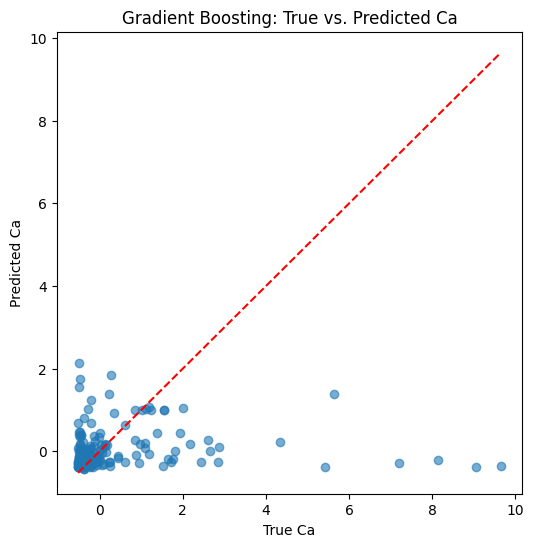

Gradient Boosting RMSE: 1.464
Gradient Boosting R^2 Score: -0.039


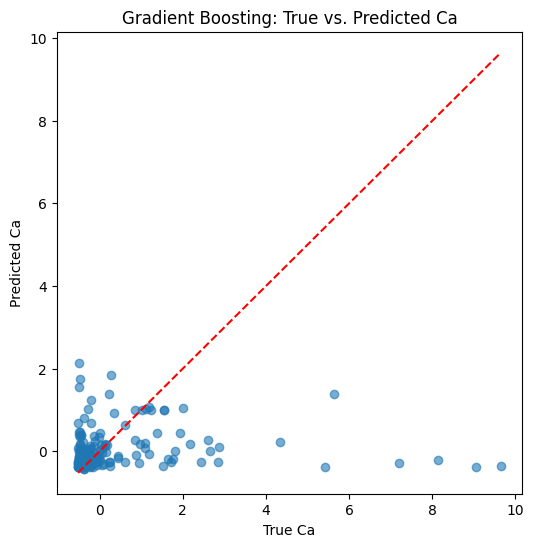

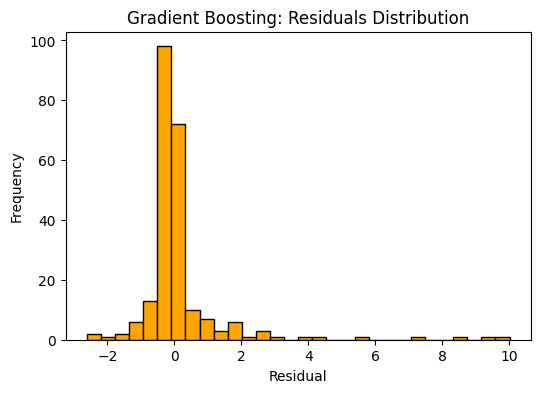

Gradient Boosting RMSE: 1.464
Gradient Boosting R^2 Score: -0.039


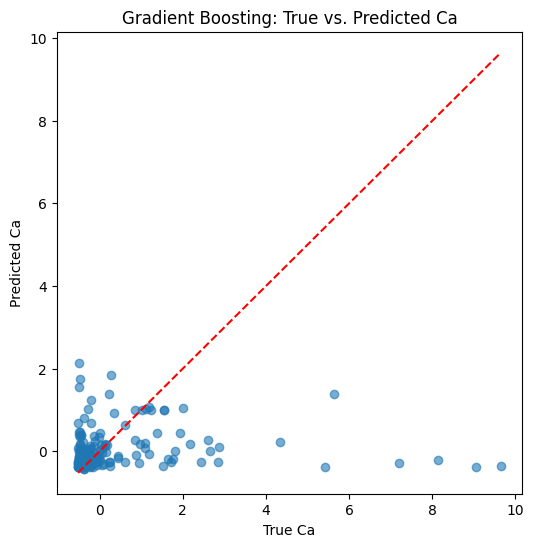

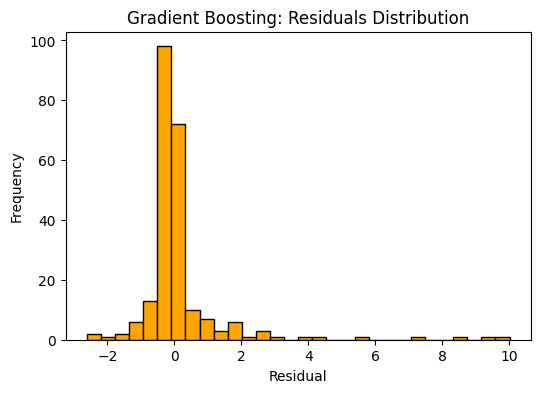

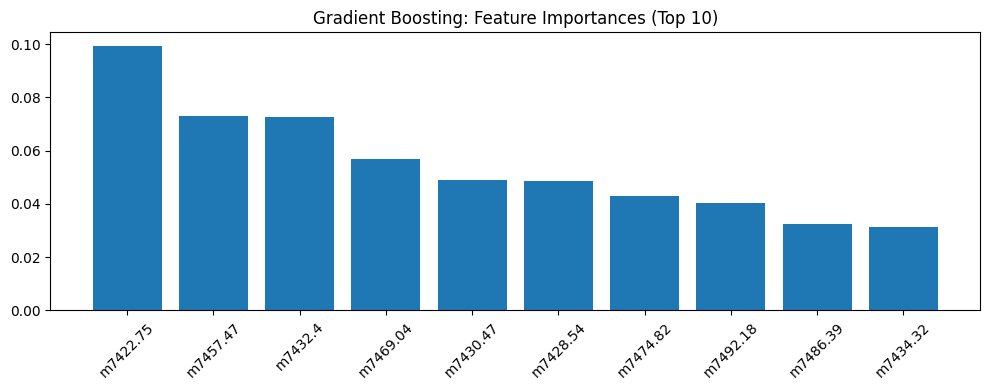

In [ ]:
# Example: Gradient Boosting for Soil Calcium Regression (data/training.csv)
# This example demonstrates boosting for regression tasks.
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

y_ca = soil['Ca'].dropna()
X_ca = soil.loc[y_ca.index, features[:50]]
y_ca = y_ca.loc[X_ca.index]

X_train_ca, X_test_ca, y_train_ca, y_test_ca = train_test_split(X_ca, y_ca, test_size=0.2, random_state=42)

gbr = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
gbr.fit(X_train_ca, y_train_ca)
y_pred_gbr = gbr.predict(X_test_ca)

print(f"Gradient Boosting RMSE: {np.sqrt(mean_squared_error(y_test_ca, y_pred_gbr)):.3f}")
print(f"Gradient Boosting R^2 Score: {r2_score(y_test_ca, y_pred_gbr):.3f}")

# Visualize predictions vs. true values
plt.figure(figsize=(6,6))
plt.scatter(y_test_ca, y_pred_gbr, alpha=0.6)
plt.xlabel('True Ca')
plt.ylabel('Predicted Ca')
plt.title('Gradient Boosting: True vs. Predicted Ca')
plt.plot([y_test_ca.min(), y_test_ca.max()], [y_test_ca.min(), y_test_ca.max()], 'r--')
plt.show()

# Visualize residuals
residuals_gbr = y_test_ca - y_pred_gbr
plt.figure(figsize=(6,4))
plt.hist(residuals_gbr, bins=30, color='orange', edgecolor='k')
plt.title('Gradient Boosting: Residuals Distribution')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

# Feature importance
importances_gbr = gbr.feature_importances_
indices_gbr = np.argsort(importances_gbr)[::-1]
plt.figure(figsize=(10,4))
plt.title("Gradient Boosting: Feature Importances (Top 10)")
plt.bar(range(10), importances_gbr[indices_gbr[:10]], align="center")
plt.xticks(range(10), [features[i] for i in indices_gbr[:10]], rotation=45)
plt.tight_layout()
plt.show()

### Histogram-based Boosting
Histogram-based Gradient Boosting (e.g., `HistGradientBoostingRegressor`) speeds up training by binning features, reducing the number of split points considered. This is especially useful for large datasets.

**Advantages:**
- Faster training on large datasets.
- Can handle missing values natively.

HistGradientBoosting RMSE: 0.951
HistGradientBoosting R^2 Score: 0.019


HistGradientBoosting RMSE: 0.951
HistGradientBoosting R^2 Score: 0.019


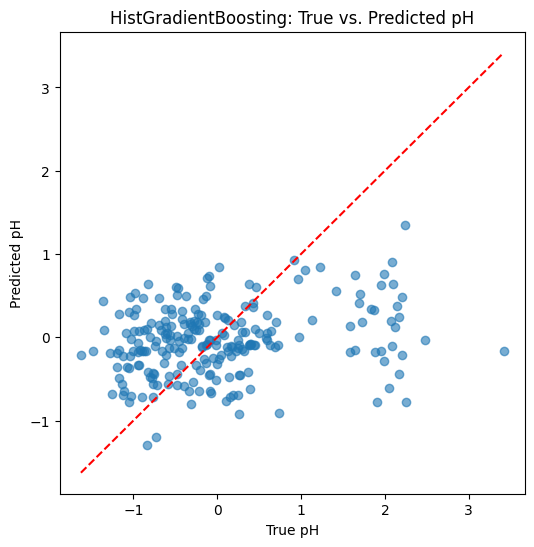

HistGradientBoosting RMSE: 0.951
HistGradientBoosting R^2 Score: 0.019


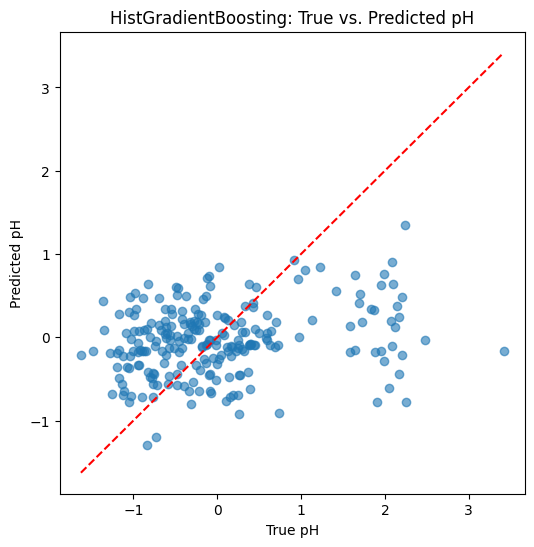

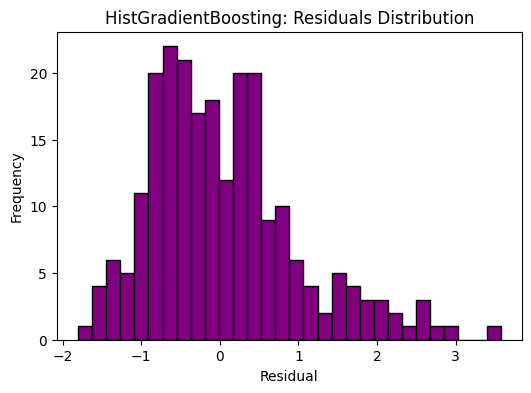

In [ ]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(soil[features[:10]], soil['pH'], test_size=0.2, random_state=42)
clf = HistGradientBoostingRegressor(max_iter=100).fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(f"HistGradientBoosting RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}")
print(f"HistGradientBoosting R^2 Score: {r2_score(y_test, y_pred):.3f}")

# Visualize predictions vs. true values
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel('True pH')
plt.ylabel('Predicted pH')
plt.title('HistGradientBoosting: True vs. Predicted pH')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

# Visualize residuals
residuals_hist = y_test - y_pred
plt.figure(figsize=(6,4))
plt.hist(residuals_hist, bins=30, color='purple', edgecolor='k')
plt.title('HistGradientBoosting: Residuals Distribution')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

# Feature importance (if available)
if hasattr(clf, 'feature_importances_'):
    importances_hist = clf.feature_importances_
    indices_hist = np.argsort(importances_hist)[::-1]
    plt.figure(figsize=(10,4))
    plt.title("HistGradientBoosting: Feature Importances (Top 10)")
    plt.bar(range(10), importances_hist[indices_hist[:10]], align="center")
    plt.xticks(range(10), [features[i] for i in indices_hist[:10]], rotation=45)
    plt.tight_layout()
    plt.show()

---

## 6. Hyperparameter Tuning & Parallelization

- **n_estimators**: Number of trees (higher = more robust, but slower)
- **max_features**: Number of features to consider at each split (RF)
- **max_depth**: Maximum depth of each tree
- **learning_rate**: Step size shrinkage (boosting)
- **n_jobs**: Number of parallel jobs (RF, Bagging)

### Grid Search Example
- Use `GridSearchCV` to tune hyperparameters.
- Use cross-validation to avoid overfitting.

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [50, 100],
    'max_features': [10, 20, 30]
}
grid = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, n_jobs=-1)
grid.fit(X_train, y_train)
print(f"Best parameters: {grid.best_params_}")
print(f"Best CV score: {grid.best_score_:.3f}")

Best parameters: {'max_features': 10, 'n_estimators': 100}
Best CV score: -0.204


---

## 7. Summary & Review Questions

### Key Takeaways
- **Bagging** reduces variance by averaging predictions from multiple models trained on bootstrap samples.
- **Random Forests** add feature randomness to further decorrelate trees and improve performance.
- **Boosting** reduces bias by sequentially focusing on errors, leading to strong predictive models.
- **Hyperparameter tuning** and **parallelization** are crucial for optimal performance.
- **Feature importance** helps interpret ensemble models.

### Review Questions
- What is the main difference between bagging and boosting?
- How does Random Forest reduce variance compared to a single decision tree?
- What does the learning rate control in gradient boosting?
- How do you interpret feature importances in Random Forests?
- Write the equations for bagging and boosting predictions.
- What are some pitfalls when using ensemble methods?
- When would you prefer boosting over bagging?
- How can you visualize the bias-variance tradeoff?